# Investment Case Group Project
***
***

### Prerequisite:
1. Download Anaconda Package from here : 
https://www.anaconda.com/download/<br>

2. Installation Instructions : 
https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444

3. MySQL driver installation for Python(Optional) : After Installing Anaconda package, on Anaconda prompt, run the below command:
<br>"conda install -c anaconda mysql-connector-python"
***

#### Import Libraries and set required parameters

In [140]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image # To view image from location/url
pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.2f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00

#### Input & Output Directory Path
#### IMPORTANT: Replace inputDir & outDir path with your directory path.

In [141]:
inputDir = 'E:/Shikhab/GitHub/PythonScripts/data/spark_funds/'
outDir = 'E:/Shikhab/GitHub/PythonScripts/data/spark_funds/outDir/'
file1 = 'companies.txt'
file2 = 'rounds2.csv'
file3 = 'mapping.csv'

dynamic = True

# dynamic = True
# Note for the English Speaking Countries if you want to dynamically get the information from MySQL > MySQl > world database > 
# country & country language table.
# Run above command as mentioned in prerequisite : conda install -c anaconda mysql-connector-python¶
# Run this command on world db > INSERT INTO COUNTRYLANGUAGE VALUES('IND','English','T',4.5)

# dynamic = False
# Manually a column will be added(by referring pdf) in top9 dataframe called IsOfficialEN

## Checkpoint 1: Data Cleaning

##### Loading datasets into pandas dataframe.

In [142]:
companies = pd.read_csv(inputDir+file1,sep='\t',encoding='iso-8859-1')
rounds2 = pd.read_csv(inputDir+file2,encoding='iso-8859-1') # Use 'iso-8859-1' for accented characters

##### Get some insight

In [143]:
companies.head(2)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014


In [144]:
rounds2.head(2)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan


### Table 1.1
#### Q1. How many unique companies are present in rounds2?

In [145]:
# .nunique() wil give Unique count(excludes NA), use .lower() , in case of duplicate enties in different case,
# .count() will give the total no of rows.

rounds2.company_permalink.str.lower().nunique()

66370

#### Q2. How many unique companies are present in companies?

In [146]:
companies.permalink.str.lower().nunique()

66368

#### Q3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.

In [147]:
# Ist Method
#nunique() will give unique values for each column, column with maximum unique counts can be considered as unique column#### 
companies.nunique().sort_values(ascending=False).iloc[0:1]

# IInd Method
# Companies.describe() will give count, unique, top etc information, we store count & unique values in a temp df and
# then subtracting unique values(1) from count(0) and giving the column name where difference is 0
#companies.describe().iloc[0:2]


permalink    66368
dtype: int64

#### Q4. Are there any companies in the rounds2 file which are not  present in companies ?

In [148]:
# Check the existacce of a unique column of dataframe1 in unique column of dataframe2
rounds2[rounds2['company_permalink'].str.lower().isin(companies['permalink'].str.lower())== False]

# Note : You may not get the difference in R, because of the different encoding.
# Python >> encoding='iso-8859-1'
# R      >> encoding='utf-8'

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
29597,/ORGANIZATION/E-CÃBICA,/funding-round/8491f74869e4fe8ba9c378394f8fbdea,seed,NaN,01-02-2015,nan
31863,/ORGANIZATION/ENERGYSTONE-GAMES-ÇµÇ³Æ¸¸Æ,/funding-round/b89553f3d2279c5683ae93f45a21cfe0,seed,NaN,09-08-2014,nan
45176,/organization/huizuche-com-æ ç§ÿè½¦,/funding-round/8f8a32dbeeb0f831a78702f83af78a36,seed,NaN,18-09-2014,nan
58473,/ORGANIZATION/MAGNET-TECH-Ç£Ç³Ç§Æ,/funding-round/8fc91fbb32bc95e97f151dd0cb4166bf,seed,NaN,16-08-2014,1625585.00
101036,/organization/tipcat-interactive-æ²èÿä¿¡æ¯ç...,/funding-round/41005928a1439cb2d706a43cb661f60f,seed,NaN,06-09-2010,nan
109969,/ORGANIZATION/WEICHE-TECH-ÅÈ½¦Ç§Æ,/funding-round/f74e457f838b81fa0b29649740f186d8,venture,A,06-09-2015,nan
113839,/ORGANIZATION/ZENGAME-Ç¦ Æ¸¸Ç§Æ,/funding-round/6ba28fb4f3eadf5a9c6c81bc5dde6cdf,seed,NaN,17-07-2010,nan


#### Q5. Merge the two data frames so that all  variables (columns)  in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame ?

In [149]:
# lower() the key columns of both dataframes, so they can match in case of diffence in case.
companies['permalink'] = companies['permalink'].str.lower()
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
master_frame = pd.merge(left = companies,right = rounds2, how ='inner', left_on='permalink',right_on='company_permalink')
print('\nNumber of Records: ',master_frame.count()[0])

# From here onwards we will work with master_frame only


Number of Records:  114942


In [150]:
# Drop Rows from master_frame where raised_amount_usd is null
master_frame = master_frame.drop(master_frame[master_frame.raised_amount_usd.isnull()].index)
print('\nNumber of Records: ',master_frame.count()[0])


Number of Records:  94958


#### Define Function to store dataframe at user location

In [151]:
# Defining a method to wite(.csv) a file to the user location.
def writeDF(dataframe,filename,dir_path):
    dataframe.to_csv(path_or_buf = outDir+filename+'.csv')
    size = str(round((os.path.getsize(outDir+filename+'.csv')/1000),1))
    print('File: '+filename+'.csv created at '+outDir+ '\nSize of file :'+size+ ' KB' )
    
# Defining a method to wite(.xlsx) a file to the user location.
def writeDF_xl(dataframe,filename,dir_path):
    writer = pd.ExcelWriter(outDir+filename+'.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
    dataframe.to_excel(writer,sheet_name= filename)
    writer.close()
    size = str(round((os.path.getsize(outDir+filename+'.xlsx')/1000),1))
    print('File: '+filename+'.xlsx created at '+outDir+ '\nSize of file :'+size+ ' KB' )

#### Storing Data(master_frame)

In [152]:
# Storing master_frame dataframe at user location, we can use this dataframe in Tableau directly.
writeDF(master_frame,'master_frame',outDir)

File: master_frame.csv created at E:/Shikhab/GitHub/PythonScripts/data/spark_funds/outDir/
Size of file :23784.3 KB


## Checkpoint 2: Funding Type Analysis
### Table 2.1 ( Average Values of Investments for Each of these Funding Types)

#### Define Function to get the avg_funding_amount for any FT

In [153]:
# defining a function to get average funding amount for any funding type.
def avg_funding_amount(funding_type):
    return master_frame[master_frame['funding_round_type']==funding_type]['raised_amount_usd'].mean()

#### Q1/2/3/4. Average funding amount of different funding type ?

In [154]:
venture = avg_funding_amount('venture')
angel = avg_funding_amount('angel')
seed = avg_funding_amount('seed')
private_equity = avg_funding_amount('private_equity')

print('venture' ,avg_funding_amount('venture'))
print('angel' ,avg_funding_amount('angel'))
print('seed' ,avg_funding_amount('seed'))
print('private_equity' ,avg_funding_amount('private_equity'))

venture 11748949.129489528
angel 958694.4697530865
seed 719779.6202016778
private_equity 73308593.02944215


#### Q5. Considering that Spark Funds wants to invest between 5 to 15 million USD per  investment round, which investment type is the most suitable for them?

In [155]:
# We can check from the last step that only venture funding type lies between 5 to 15 million.
# Alternatively we can find the funding type through below code:
## [['']] double brackets or (.reset_index()) are used to keep the dataframe , if we use [''], it will be converted into series

most_suitable = master_frame.groupby(by='funding_round_type')[['raised_amount_usd']].mean()
most_suitable = most_suitable[(most_suitable.raised_amount_usd >= 5000000) & (most_suitable.raised_amount_usd <= 15000000)]
most_suitable

,raised_amount_usd
funding_round_type,
venture,11748949.13


In [156]:
# Filter the master_frame dataset based on the above conditions(funding_round_type)
master_frame_filtered = master_frame[master_frame.funding_round_type == most_suitable.index[0]]

print('\nNumber of Records: ',master_frame_filtered.count()[0])
master_frame_filtered.head(3)

# Now master_frame_filtered contains the data where funding_round_type ='venture' & raised_amount_usd between 5 to 15 million.


Number of Records:  50228


,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00
3,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.00
4,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.00


## Checkpoint 3: Country Analysis
### Table 3.1 ( Analysing the Top 3 English-Speaking Countries)

In [157]:
top9 = master_frame_filtered.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False).reset_index()[0:9]
print('Number of Records in top9:' ,top9.shape[0])

Number of Records in top9: 9


###### Add a new column identifier, IsOfficialEN in top9 dataframe.

In [158]:
# Now the requirement is to fetch top 3 countries from top 9 dataframe where official language is English, we will fetch this 
# information from MySQl > world database > country & country language table. Alternatively we can check this information
# from the pdf provided, but there we have to hardcode the information.

if dynamic:
    import mysql.connector as con
    db_connection = con.connect(host='localhost', database='world', user='root', password='mysql@123')
    query = 'select code,name from country where code in(SELECT countrycode FROM COUNTRYLANGUAGE WHERE LANGUAGE=%s AND ISOFFICIAL=%s)'
    countryEN =  pd.read_sql(sql =query,con =db_connection,params=['English','T'])
    top9['IsOfficialEN'] = top9.country_code.isin(countryEN['code'])
else:
    top9['IsOfficialEN'] = [True,False,True,True,True,False,False,False,False]
    
top9

,country_code,raised_amount_usd,IsOfficialEN
0,USA,422510842796.00,True
1,CHN,39835418773.00,False
2,GBR,20245627416.00,True
3,IND,14391858718.00,True
4,CAN,9583332317.00,True
5,FRA,7259536732.00,False
6,ISR,6907514579.00,False
7,DEU,6346959822.00,False
8,JPN,3363676611.00,False


#### Storing Data(top9)

In [159]:
# Storing top9 dataframe at user location
writeDF(top9,'top9',outDir)

File: top9.csv created at E:/Shikhab/GitHub/PythonScripts/data/spark_funds/outDir/
Size of file :0.3 KB


#### Q1/2/3. Top/Second/Third English speaking country ?

In [160]:
top3 = top9[top9.IsOfficialEN].iloc[0:3,0:2].reset_index()
top = top3.country_code[0]
second = top3.country_code[1]
third = top3.country_code[2]

print('top ',top)
print('second ',second)
print('third ',third)

top  USA
second  GBR
third  IND


In [161]:
# Filter master_frame_filtered dataset based on top 3 english speaking countries
top3_data = master_frame_filtered.loc[master_frame_filtered.country_code.isin(top3.country_code)]
print('\nNumber of Records: ',top3_data.count()[0])
top3_data.head(3)


Number of Records:  39018


,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00
10,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,09-11-2015,20000000.00
11,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,03-01-2013,1700000.00


## Checkpoint 4: Sector Analysis 1
### Table 5.1 ( Sector-wise Investment Analysis)

In [162]:
# first string before the | will be considered the primary sector.
# Add the new column in master_frame_filtered dataframe named as 'primary_sector'
top3_data['primary_sector'] = top3_data['category_list'].str.split('|').str.get(0)

print('\nNumber of Records: ',top3_data.count()[0])
top3_data.head(3)


Number of Records:  39018


,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00,Media
10,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,09-11-2015,20000000.00,Analytics
11,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,/organization/0xdata,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,03-01-2013,1700000.00,Analytics


In [163]:
mapping =  pd.read_csv(inputDir+file3,encoding='iso-8859-1') # Use 'iso-8859-1' for accented characters
print('\nNumber of Records in mapping: ',mapping.shape[0]) # shape includes NA


Number of Records in mapping:  688


##### Clean Mapping.csv(replace 0 with na)

In [164]:
# There are multiple records in the dataset column category_list where 'na' is replaced by 0, so we have to replace 0 with na,
# we have to make sure if data contains 2.0 or v3.0 we should not replace it.
# '.*' is for zero or more occurances before 0, '.+ is for one or more occurance after 0.

regex = (mapping.category_list.str.contains('[.*0]')==True) &  (mapping.category_list.str.endswith('0')==False)
mapping_cleaned = mapping.copy()
mapping_cleaned.loc[regex,'category_list'] = mapping_cleaned.loc[regex,'category_list'].replace('0','na',regex=True)
mapping_cleaned.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


#### Define Function(demap)

In [165]:
# Defining function demap, which will convert data in mapping dataframe above to two columns output.
def demap(df,outColName):
    l = list()
    c = int(df.count().sort_values(ascending=False)[0])
    for i in range(c):
        for col_name in df.columns:
            if df[col_name][i]==1:
               l.append(col_name)
    df2 = df.copy()
    df2[outColName] = l
    return df2.iloc[:,[0,-1]]

##### Map Category List with Main Sector

In [166]:
mapping_new = demap(mapping_cleaned,'main_sector')
mapping_new.tail()

,category_list,main_sector
683,Wholesale,Others
684,Wine And Spirits,Entertainment
685,Wireless,Entertainment
686,Women,Others
687,Young Adults,Others


##### Merge Top3 data with mapping

In [167]:
top3_data_sector_wise = pd.merge(left=top3_data, right=mapping_new,left_on='primary_sector',right_on='category_list')
# Drop unnecessary columns
top3_data_sector_wise.drop(labels=['category_list_x', 'category_list_y'],axis=1, inplace=True)

print('\nNumber of Records: ',top3_data_sector_wise.count()[0])
top3_data_sector_wise.head(3)


Number of Records:  38857


,permalink,name,homepage_url,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,http://livfame.com,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00,Media,Entertainment
1,/organization/90min,90min,http://www.90min.com,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,NaN,06-10-2015,15000000.00,Media,Entertainment
2,/organization/90min,90min,http://www.90min.com,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,NaN,07-05-2013,5800000.00,Media,Entertainment


#### Storing Data (top3_data_sector_wise)

In [168]:
# Storing master_frame_sector_wise dataframe at user location
# top3_data_sector_wise :: Contains the data for top3 english speaking countries where a particular funding type falling 
#within the 5-15 million USD range.

writeDF(top3_data_sector_wise,'top3_data_sector_wise',outDir)

File: top3_data_sector_wise.csv created at E:/Shikhab/GitHub/PythonScripts/data/spark_funds/outDir/
Size of file :10044.0 KB


## Checkpoint 5: Sector Analysis 2

Created three separate data frames D1, D2 and D3 for each of the three english countries containing the observations of funding type falling within the 5-15 million USD range.
The three data frames should contain:
1. All the columns of the master_frame along with the primary sector and the main sector
2. The total number (or count) of investments for each main sector in a separate column
3. The total amount invested in each main sector in a separate column

In [169]:
#USA
D1 = top3_data_sector_wise[top3_data_sector_wise['country_code']==top]

#GBR
D2 = top3_data_sector_wise[top3_data_sector_wise['country_code']==second]

#IND
D3 = top3_data_sector_wise[top3_data_sector_wise['country_code']==third]

D1.head(3)

,permalink,name,homepage_url,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
4,/organization/all-def-digital,All Def Digital,http://alldefdigital.com,operating,USA,CA,Los Angeles,Los Angeles,NaN,/organization/all-def-digital,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,A,06-08-2014,5000000.00,Media,Entertainment
5,/organization/audiosocket,Audiosocket,http://audiosocket.com,operating,USA,WA,Seattle,Seattle,01-05-2008,/organization/audiosocket,/funding-round/0959f59e3a89bc8db8c6ed9c646349fd,venture,NaN,02-05-2013,650000.00,Media,Entertainment
6,/organization/audiosocket,Audiosocket,http://audiosocket.com,operating,USA,WA,Seattle,Seattle,01-05-2008,/organization/audiosocket,/funding-round/4e3a53eec6c609943df752206070b23f,venture,A,02-09-2009,750000.00,Media,Entertainment


#### Q1. Total number of Investments (count)

In [170]:
print(D1.count()[0])
print(D2.count()[0])
print(D3.count()[0])

35984
2049
824


 #### Q2. Total amount of investment (USD)

In [171]:
print(D1.raised_amount_usd.sum())
print(D2.raised_amount_usd.sum())
print(D3.raised_amount_usd.sum())

421038036896.0
20156617818.0
14391858718.0


##### Define function to get top sectors count and name

In [172]:
def getSector(dataset,n,identifier):
    # dataset     :: datframe
    # n           :: n represents nth order, 0 for top, 1 for second top and so on.
    # identifier  :: identifier = 'count' to get the count, identifier = 'name' to get the sector name.
    if identifier == 'name':
        return (dataset.groupby(by='main_sector')['main_sector'].count().sort_values(ascending=False).index[n])
    elif identifier == 'count':
        return (dataset.groupby(by='main_sector')['main_sector'].count().sort_values(ascending=False)[n])

#### Q3. Top sector (based on count of investments)

In [173]:
D1_sec0_name = getSector(dataset=D1,n=0,identifier='name')
D2_sec0_name = getSector(D2,0,'name')
D3_sec0_name = getSector(D3,0,'name')

print('D1_sec0_name : ',D1_sec0_name,'\nD2_sec0_name : ',D2_sec0_name,'\nD3_sec0_name : ',D3_sec0_name)

D1_sec0_name :  Others 
D2_sec0_name :  Others 
D3_sec0_name :  Others


#### Q4. Second-best sector (based on count of investments)

In [174]:
D1_sec1_name = getSector(D1,1,'name')
D2_sec1_name = getSector(D2,1,'name')
D3_sec1_name = getSector(D3,1,'name')

print('D1_sec1_name : ',D1_sec1_name,'\nD2_sec1_name : ',D2_sec1_name,'\nD3_sec1_name : ',D3_sec1_name)

D1_sec1_name :  Cleantech / Semiconductors 
D2_sec1_name :  Cleantech / Semiconductors 
D3_sec1_name :  Social, Finance, Analytics, Advertising


#### Q5. Third-best sector (based on count of investments)

In [175]:
D1_sec2_name = getSector(D1,2,'name')
D2_sec2_name = getSector(D2,2,'name')
D3_sec2_name = getSector(D3,2,'name')

print('D1_sec2_name : ',D1_sec2_name,'\nD2_sec2_name : ',D2_sec2_name,'\nD3_sec2_name : ',D3_sec2_name)

D1_sec2_name :  Social, Finance, Analytics, Advertising 
D2_sec2_name :  Social, Finance, Analytics, Advertising 
D3_sec2_name :  News, Search and Messaging


#### Q6. Number of investments in the top sector (refer to point 3)

In [176]:
D1_sec0_count = getSector(D1,0,'count')
D2_sec0_count = getSector(D2,0,'count')
D3_sec0_count = getSector(D3,0,'count')

print('D1_sec0_count : ',D1_sec0_count,'\nD2_sec0_count : ',D2_sec0_count,'\nD3_sec0_count : ',D3_sec0_count)

D1_sec0_count :  8314 
D2_sec0_count :  516 
D3_sec0_count :  284


#### Q7. Number of investments in the second-best sector (refer to point 4)

In [177]:
D1_sec1_count = getSector(D1,1,'count')
D2_sec1_count = getSector(D2,1,'count')
D3_sec1_count = getSector(D3,1,'count')

print('D1_sec1_count : ',D1_sec1_count,'\nD2_sec1_count : ',D2_sec1_count,'\nD3_sec1_count : ',D3_sec1_count)

D1_sec1_count :  7857 
D2_sec1_count :  437 
D3_sec1_count :  147


#### Q8. Number of investments in the third-best sector (refer to point 5)

In [178]:
D1_sec2_count = getSector(D1,2,'count')
D2_sec2_count = getSector(D2,2,'count')
D3_sec2_count = getSector(D3,2,'count')

print('D1_sec2_count : ',D1_sec2_count,'\nD2_sec2_count : ',D2_sec2_count,'\nD3_sec2_count : ',D3_sec2_count)

D1_sec2_count :  7246 
D2_sec2_count :  421 
D3_sec2_count :  130


#### Q9. For the top sector count-wise (point 3), which company received the highest investment?

In [179]:
# Filter dataframes by top-sector names(Q3), then group by company name and sum the raised_amount_usd, then fetch highest value
D1_com0_invt = D1[D1.main_sector == D1_sec0_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
D2_com0_invt = D2[D2.main_sector == D2_sec0_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
D3_com0_invt = D3[D3.main_sector == D3_sec0_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]

print('D1_com0_invt : ',D1_com0_invt,'\nD2_com0_invt : ',D2_com0_invt,'\nD3_com0_invt : ',D3_com0_invt)

D1_com0_invt :  SoFi 
D2_com0_invt :  OneWeb 
D3_com0_invt :  Flipkart


#### Q10. For the second-best sector count-wise (point 4), which company received the highest investment?

In [180]:
D1_com1_invt = D1[D1.main_sector == D1_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]
D2_com1_invt = D2[D2.main_sector == D2_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]
D3_com1_invt = D3[D3.main_sector == D3_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]

print('D1_com1_invt : ',D1_com1_invt,'\nD2_com1_invt : ',D2_com1_invt,'\nD3_com1_invt : ',D3_com1_invt)

D1_com1_invt :  Juno Therapeutics 
D2_com1_invt :  ReNeuron Group 
D3_com1_invt :  LYCOS Internet Limited


## Checkpoint 6: Plots

#### Q1. A plot showing the fraction of total investments (globally) in venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

##### Using Matplotlib

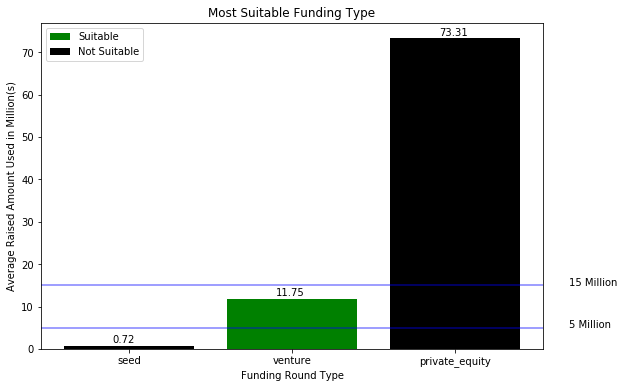

In [181]:
selected_funding_round_type = ['venture','seed','private_equity']
plot_frame = master_frame.loc[master_frame.funding_round_type.isin(selected_funding_round_type)]
plot_frame = plot_frame.groupby('funding_round_type')['raised_amount_usd'].mean().sort_values(ascending=True).reset_index()
#plot_frame_sum = plot_frame.groupby('funding_round_type')['raised_amount_usd'].sum().sort_values(ascending=True).reset_index()

cond = ((plot_frame.raised_amount_usd >= 5000000) & (plot_frame.raised_amount_usd <= 15000000))

#x_sum = range(len(plot_frame_sum.funding_round_type))
#y_sum = plot_frame_sum.raised_amount_usd/ 1000000

x = range(len(plot_frame.funding_round_type))
y = plot_frame.raised_amount_usd/ 1000000
y1 = y[cond]
y2 = y[~cond]
x1 = list(y1.index)
x2 = list(y2.index)

#plt.subplot(1,1,1)
plt.figure(figsize=(9,6))

# Bar plot
#plt.bar(x,y, color=cond.map({True: 'g', False: 'k'}),label ='Suitable' )
plt.bar(x1,y1, color='g',label ='Suitable' )
plt.bar(x2,y2, color='k',label ='Not Suitable' )


# Title
plt.title('Most Suitable Funding Type')

# Labels
plt.xlabel('Funding Round Type')
plt.ylabel('Average Raised Amount Used in Million(s)')

# Ticks
plt.xticks(x, plot_frame.funding_round_type)

# Horizontal Line
plt.axhline(y=5, color='b', linestyle='-',alpha = 0.5)
plt.text(max(x)+.7, 5,'5 Million')
plt.axhline(y=15, color='b', linestyle='-',alpha = 0.5)
plt.text(max(x)+.7, 15,'15 Million')

# Add Values to the bar
for i in x:
    plt.text(x[i]-.1,y[i]+.75,round(y[i],2))

# Legend
plt.legend()



# Save as image
plt.savefig(outDir+'Funding_Type.png',bbox_inches="tight")

# Show plot
plt.show()

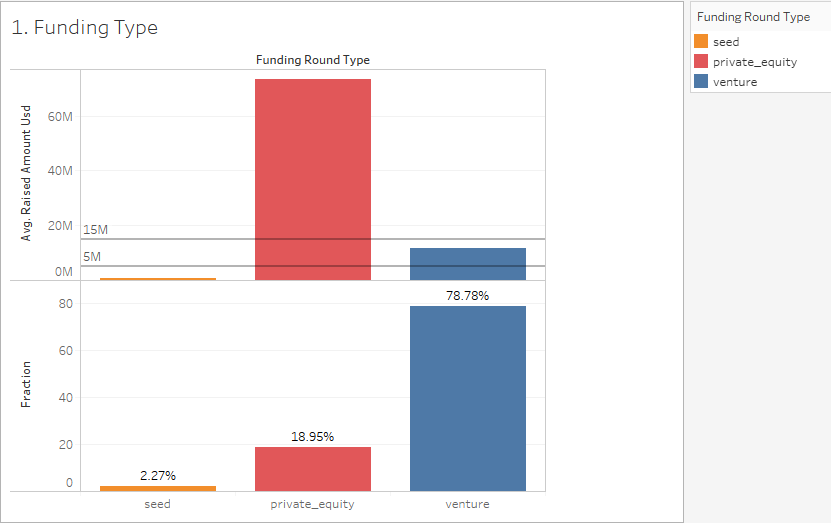

In [182]:
Image(filename = outDir + "Tableau/1 FundingType.png", width=980, height=900)

#### Q2. A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

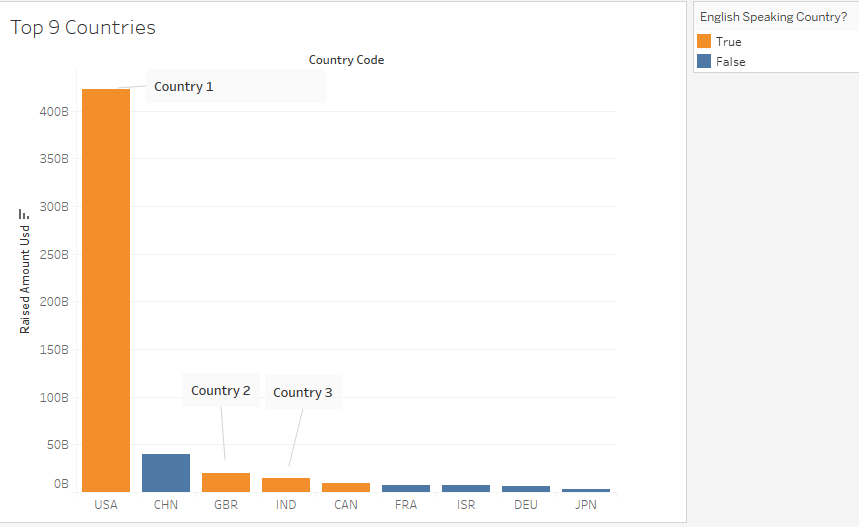

In [183]:
Image(filename = outDir + "Tableau/2 Top 9 Countries.png", width=900, height=800)

#### Q3. A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). 

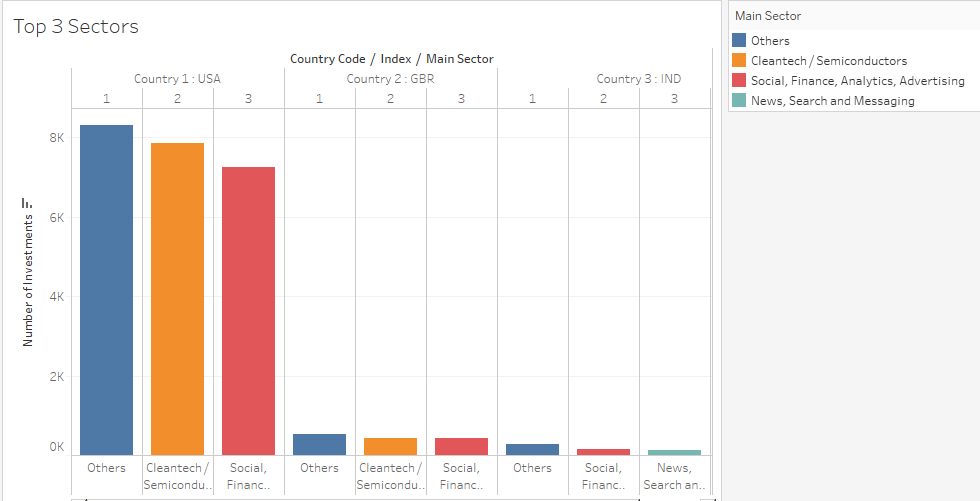

In [184]:
Image(filename = outDir + "Tableau/3 Top 3 Sectors.png", width=1000, height=1000)